In [263]:
import json
import nltk
import os
import re
import spacy
import sys
import time
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.util import ngrams
from pathlib import Path
from typing import Any, Dict, List


import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [264]:
analyzer = SentimentIntensityAnalyzer()
scaler = MinMaxScaler(feature_range=(1, 10))

In [265]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/tomlauth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tomlauth/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomlauth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [266]:
movies = {
    13: "Forrest Gump",
    120: "The Lord of the Rings: The Fellowship of the Ring",
    330: "The Lost World: Jurassic Park",
    480105: "47 Meters Down: Uncaged",
    568: "Apollo 13",
    436270: "Black Adam",
    49013: "Cars 2",
    23483: "Kick-Ass",
    268896: "Pacific Rim: Uprising",
    676: "Pearl Harbor"
}


all_users = None
with open("../test.json", "r") as file:
    all_users = json.load(file)

In [268]:
def get_reviews_by_movie_ids(reviews, movie_ids):
    results = {}

    for _, user_reviews in reviews.items():
        for review_data in user_reviews.values():
            movie_id = review_data["movie_id"]

            if movie_id in movie_ids:
                movie_name = movie_ids[movie_id]

                if movie_name not in results:
                    results[movie_name] = []

                results[movie_name].append(review_data)

    return results

filtered_reviews = get_reviews_by_movie_ids(all_users, movies)
# filtered_reviews

# Create the scores for each movie

In [269]:
def create_movie_final_scores(filtered_reviews: Dict[str, List[Dict[str, any]]], values_to_leave_out: List[any]) -> Dict[str, Dict[str, any]]:
    
    result = {}
    print(f"Rating values to leave out: {values_to_leave_out}")
    
    for movie, reviews in filtered_reviews.items():
        count_of_ratings = 0
        total_rating = 0
        total_compound = 0
        normalized_total_compound = 0
        
        for review in reviews:
            total_compound_of_bigrams = 0
            
            rating = review.get("rating", None)
            
            # print(f"Movie: {movie}\nReview: {review}\n")
            
            # Sentiment analysis for a whole review
            # Compound score > 0.05: Positive sentiment
            # Compound score < -0.05: Negative sentiment
            # Compound score between -0.05 and 0.05: Neutral sentiment
            sentiment_scores = analyzer.polarity_scores(review["content"])
            sentiment_score = sentiment_scores["compound"]

            # Normalize the sentiment score
            sentiment_values = np.array(list(sentiment_scores.values())).reshape(-1, 1)
            normalized_sentiment_values = scaler.fit_transform(sentiment_values)
            normalized_sentiment_scores = {key: normalized_sentiment_values[i][0] for i, key in enumerate(sentiment_scores.keys())}
            normalized_sentiment_score = normalized_sentiment_scores["compound"]

            # TODO: Calculate for the 5 most common words a new sentiment analysis
            # tokens = nltk.word_tokenize(review["content"].lower())
            # stop_words = set(stopwords.words('english'))
            # filtered_words = [word for word in tokens if word not in stop_words and len(word) > 4]
            # word_counts = Counter(filtered_words)
            # top_words = word_counts.most_common(5)

            # bigrams = list(ngrams(filtered_words, 2))
            # bigram_counts = Counter(bigrams)
            # top_bigrams = bigram_counts.most_common(5)
            # print(f"Top words: {top_words}, top bigrams: {top_bigrams}")

            # top_bigrams = [' '.join(bigram) for (bigram, _) in top_bigrams]
            # print(f"Top bigrams: {top_bigrams}")
            
            # print(f"Tokens: {tokens}, filtered words: {filtered_words}, word counts: {word_counts}, top words: {top_words}")

            # common_words_sentiment_scores = {}
            # default_scores = [] # This is for normalising the values 
            # for bigram in top_bigrams:
            #     score = analyzer.polarity_scores(bigram)
            #     common_words_sentiment_scores[bigram] = score["compound"]
            #     default_scores.append(common_words_sentiment_scores[bigram])
            #     total_compound_of_bigrams += common_words_sentiment_scores[bigram]

            # normalized_scores = scaler.fit_transform(np.array(default_scores).reshape(-1, 1))

            # print(f"Common words sentiment score: {common_words_sentiment_scores}, total compound of bigrams: {total_compound_of_bigrams}, normalized bigram score: {normalized_scores}")
            
            if rating in values_to_leave_out:
                continue
            
            total_rating += rating
            count_of_ratings += 1
            total_compound += sentiment_score
            normalized_total_compound += normalized_sentiment_score
            # print(total_rating)
            
        avg_rating = total_rating / count_of_ratings
        avg_compound_score = total_compound / count_of_ratings
        normalized_avg_compound_score = normalized_total_compound / count_of_ratings
        rating_norm_sentiment_divided = (avg_rating + normalized_avg_compound_score) / 2
    
        result[movie] = {
            "rating": total_rating,
            "avg_rating": avg_rating,
            "total_compound_score": total_compound,
            "avg_compound_score": avg_compound_score,
            "normalized_total_compound_score": normalized_total_compound,
            "normalized_avg_compound_score": normalized_avg_compound_score,
            "rating_norm_sentiment_divided": rating_norm_sentiment_divided
        }

        # print(result)
    
    return result

result_without_none_rating_values = create_movie_final_scores(filtered_reviews, values_to_leave_out=[None])
result_without_1_10_none_rating_values = create_movie_final_scores(filtered_reviews, values_to_leave_out=[1,10,None])
result_without_2_9_none_rating_values = create_movie_final_scores(filtered_reviews, values_to_leave_out=[2,9,None])
result_without_1_2_9_10_none_rating_values = create_movie_final_scores(filtered_reviews, values_to_leave_out=[1,2,9,10,None])

Rating values to leave out: [None]
Rating values to leave out: [1, 10, None]
Rating values to leave out: [2, 9, None]
Rating values to leave out: [1, 2, 9, 10, None]


# Create the plots

In [270]:
def create_plot(result: Dict[str, Dict[str, any]]) -> None:
    movies = list(result.keys())
    avg_ratings = [metrics['avg_rating'] for metrics in result.values()]
    normalized_sentiments = [metrics['normalized_avg_compound_score'] for metrics in result.values()]
    rating_norm_sentiments = [metrics['rating_norm_sentiment_divided'] for metrics in result.values()]
    differences = [metrics["avg_rating"] - metrics["normalized_avg_compound_score"] for metrics in result.values()]

    categories = [
        ("Average Rating", avg_ratings),
        ("Normalized Average Sentiment", normalized_sentiments),
        ("(Avg Rating + Sentiment) / 2", rating_norm_sentiments),
        ("Difference (Average Rating - Normalized Sentiment)", differences)
    ]
    
    for (title, value) in categories:
    
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.bar(movies, value)
        ax.set_title(title)
        ax.set_ylabel('Values')
        ax.set_xticks(range(len(movies)))
        ax.set_xticklabels(movies, rotation=90)
        ax.set_xlabel('Movies')

        if "Difference" in title:
            ax.axhline(0, color='black', linewidth=1, linestyle='-')
    
        plt.tight_layout()
        plt.show()

# Interpretation of the different values of the categories:

### Average rating:
- This represents the average rating of the movie, on the diagramms there is a scale of 0 to 10.

### Normalized average sentiment:
- This is a metric derived from the user reviews and reflects the general mood or sentiment towards the movie, scaled to the same range as the ratings.

### (Avg Rating + normalized average sentiment) / 2
- This is the mean value between the average rating and the normalized sentiment. It gives a combined impression of how the film is seen in terms of both rating and sentiment.

### Difference (Average Rating - Normalized average sentiment):

- Positive values -> The Average Rating is higher than the Normalized Sentiment. This could indicate 
that the average rating is better than the sentiment or emotional reactions reflected in the reviews.
The movie might have been rated as high quality, although opinions were more mixed or less positive.

- Negative values -> The Normalized Sentiment is higher than the Average Rating. This could mean
that the moods or opinions in the reviews are more positive than the average ratings suggest. 
The film may have been perceived more positively emotionally than the rating indicates.

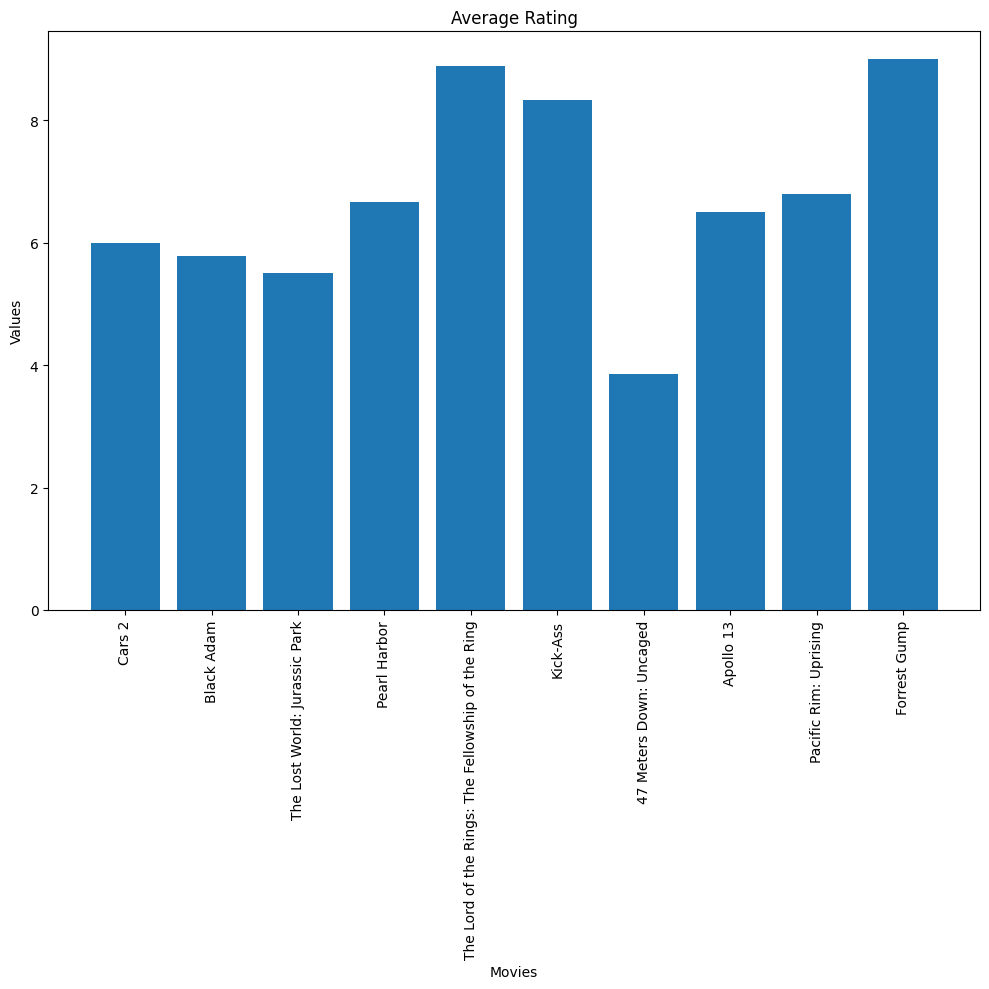

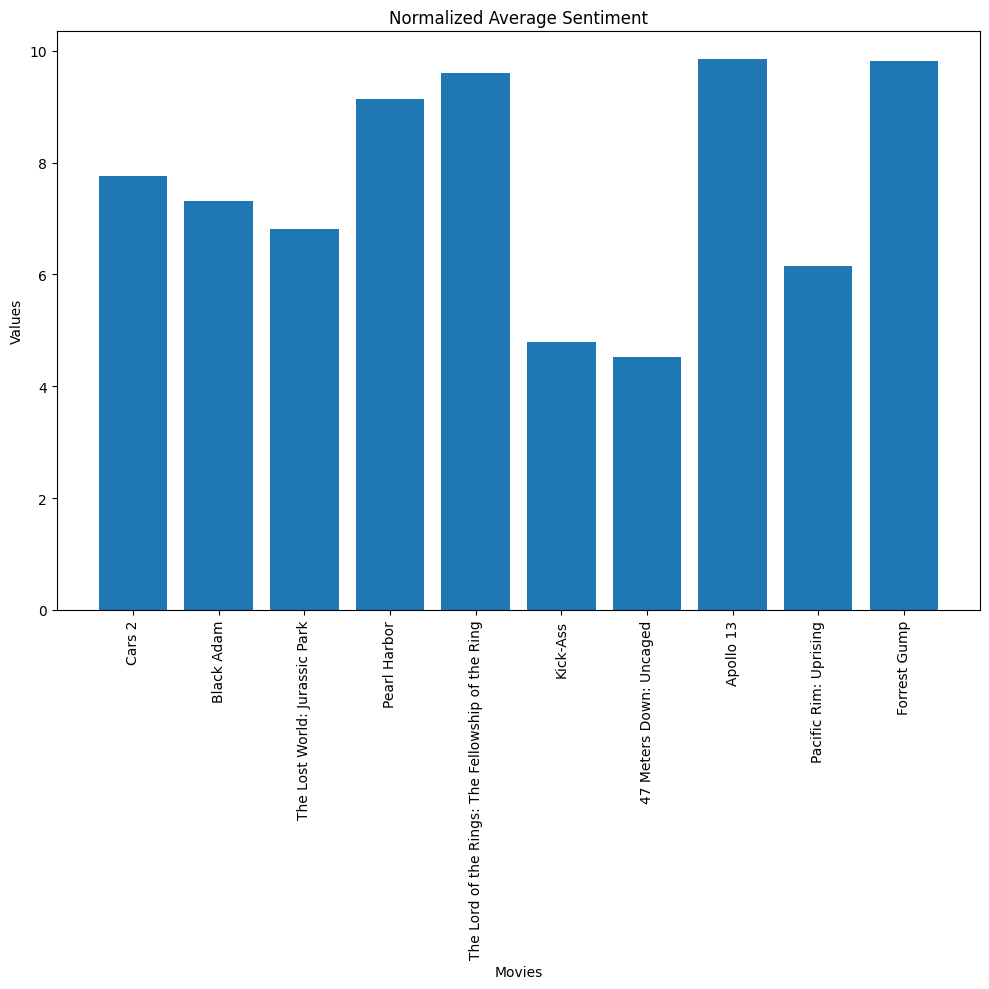

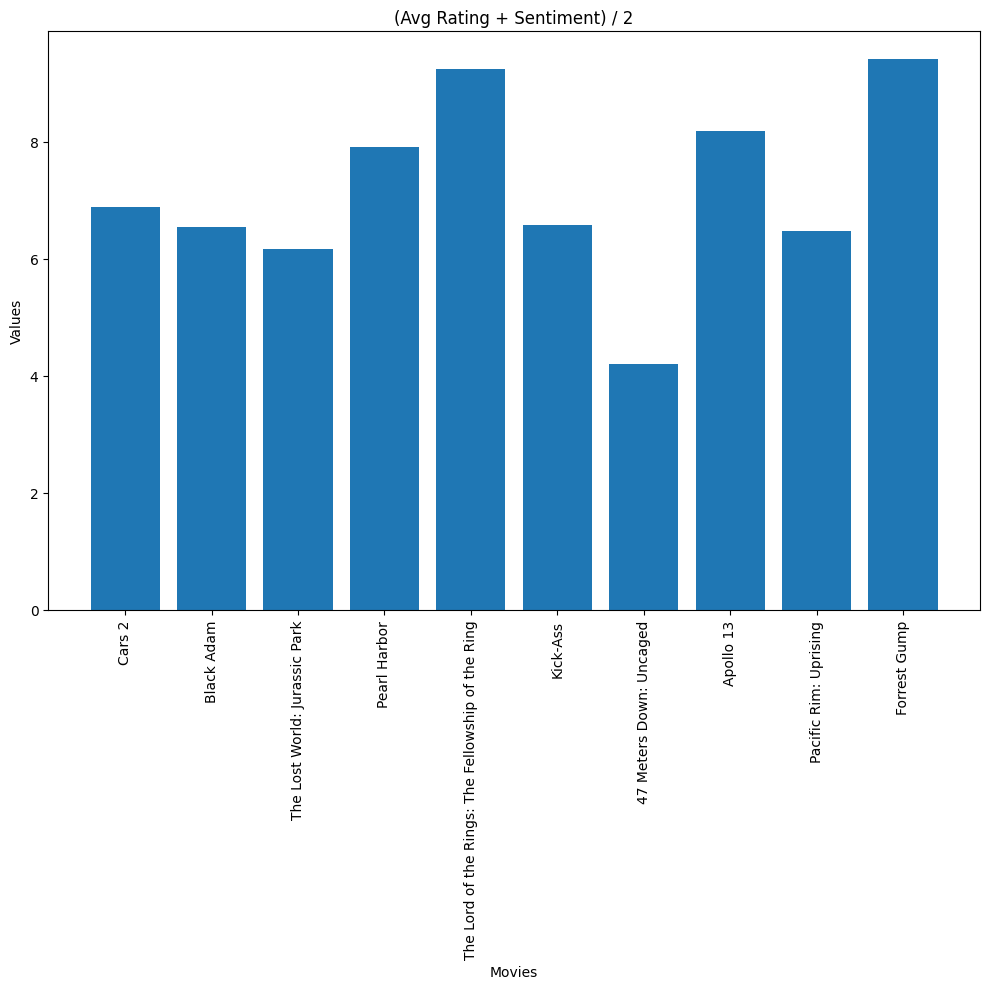

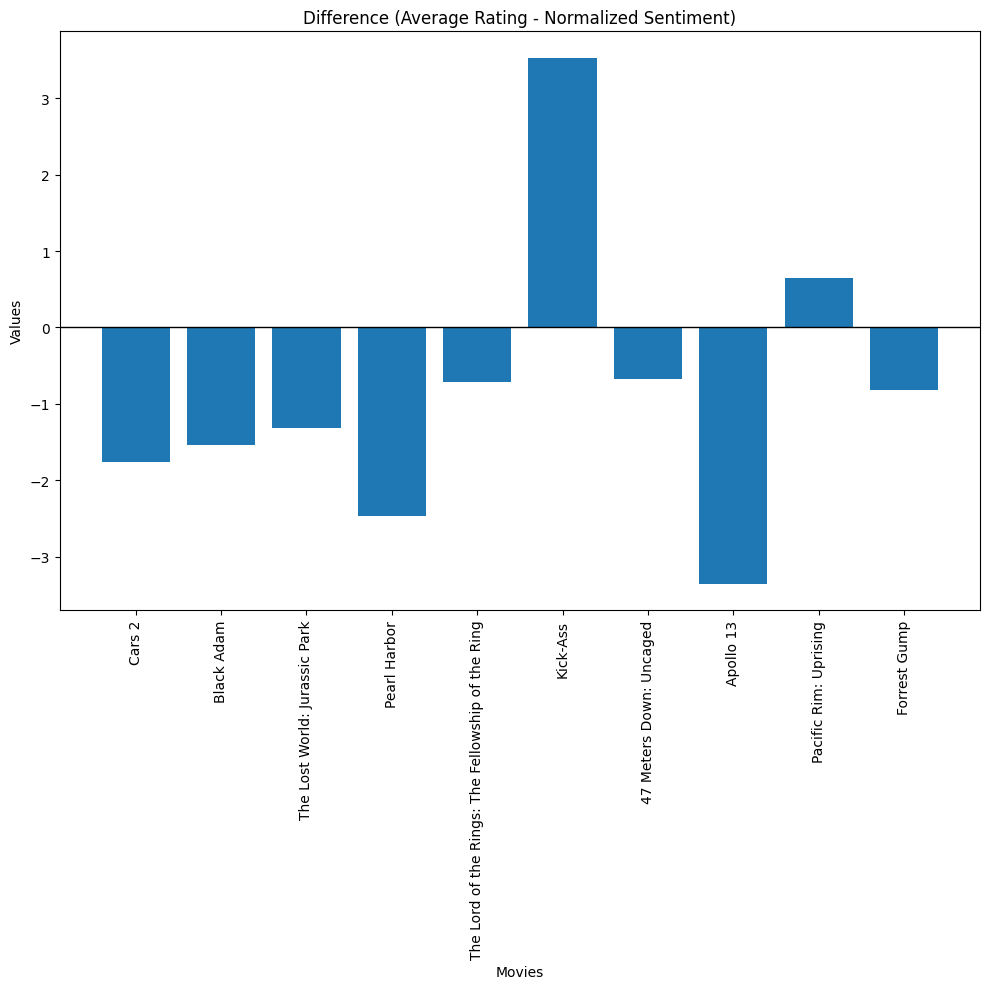

In [271]:
create_plot(result_without_none_rating_values)

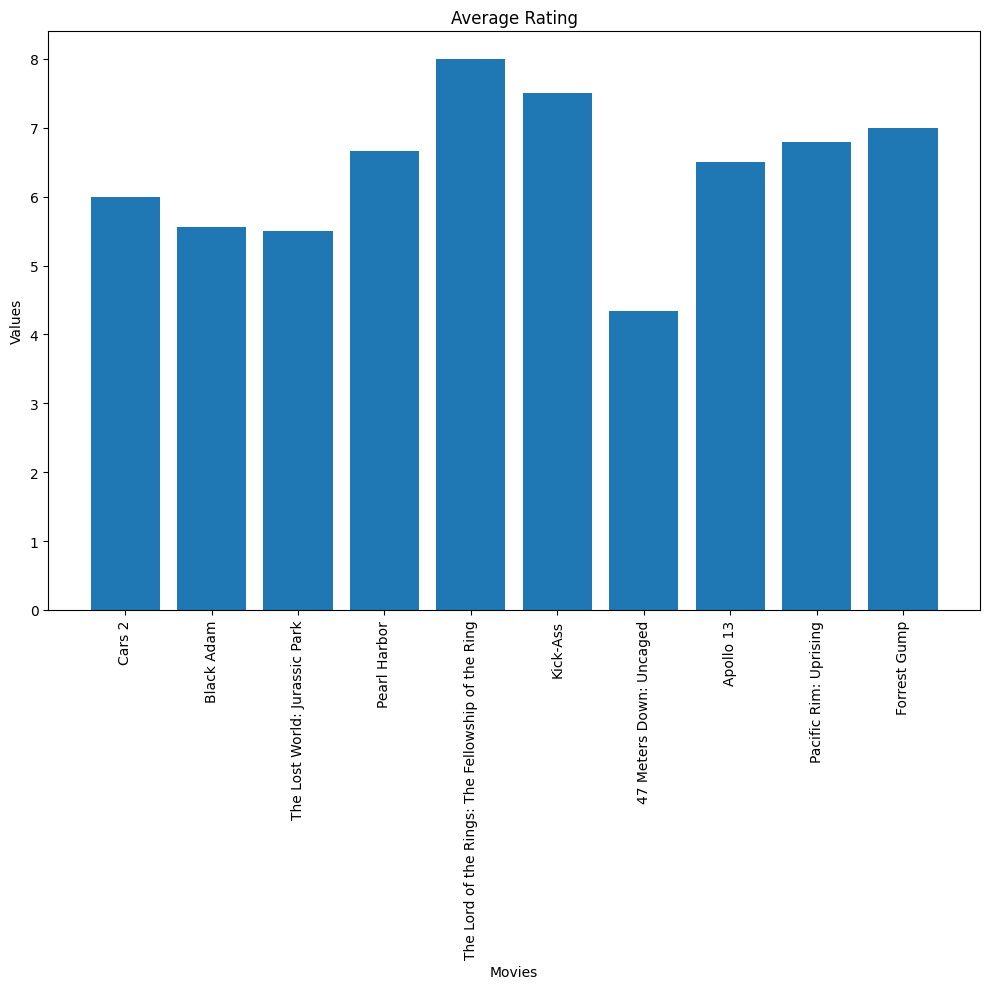

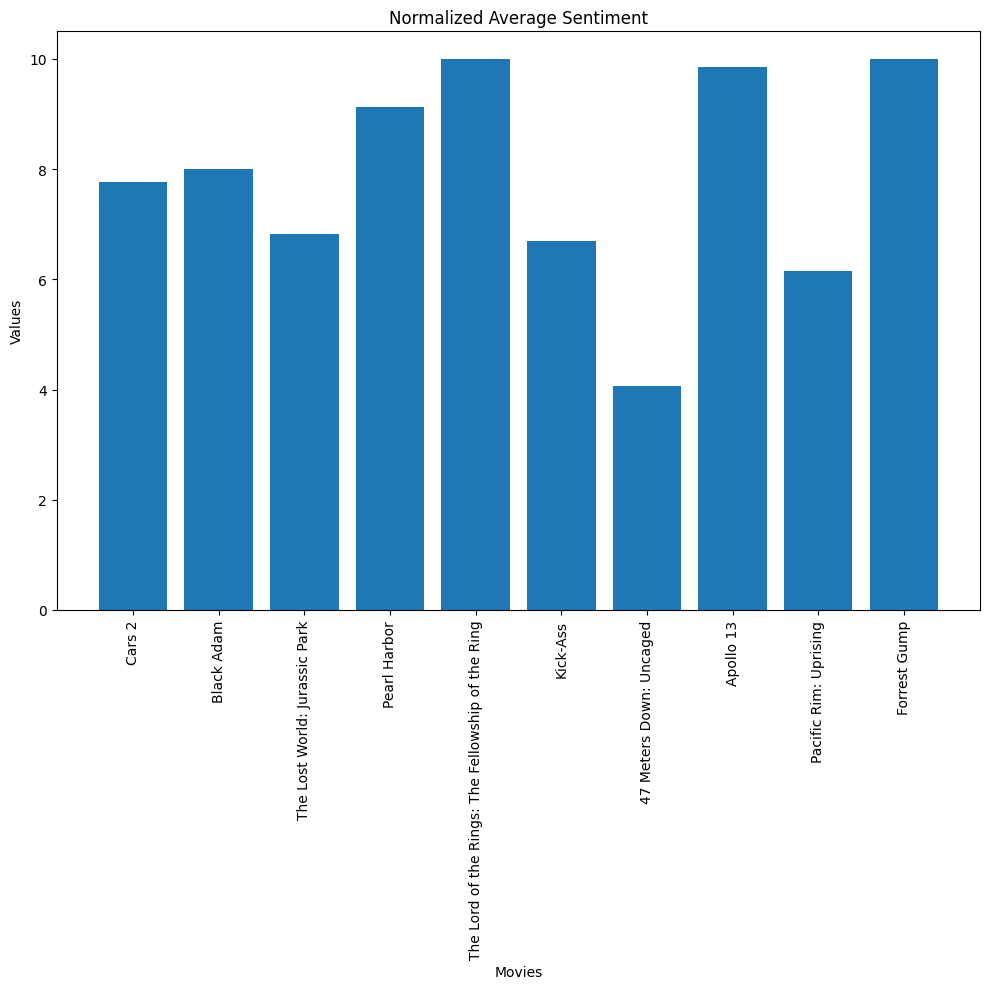

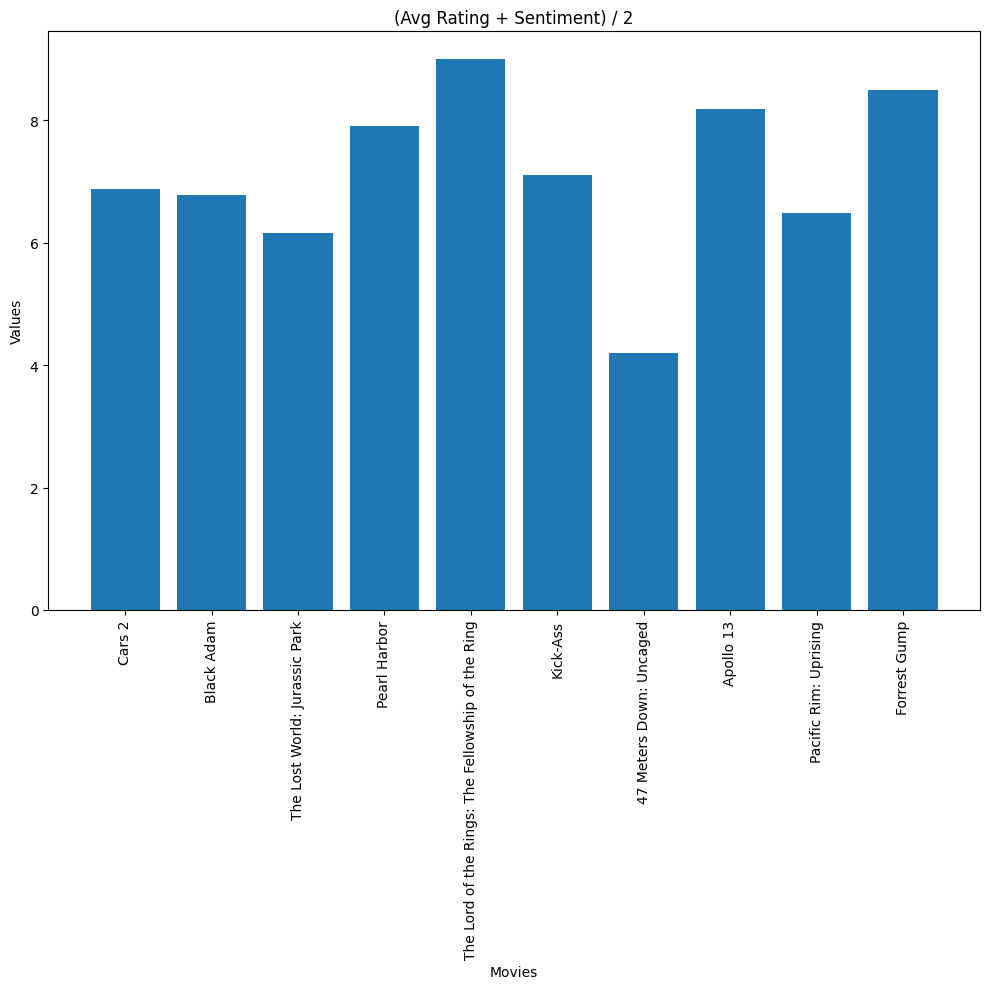

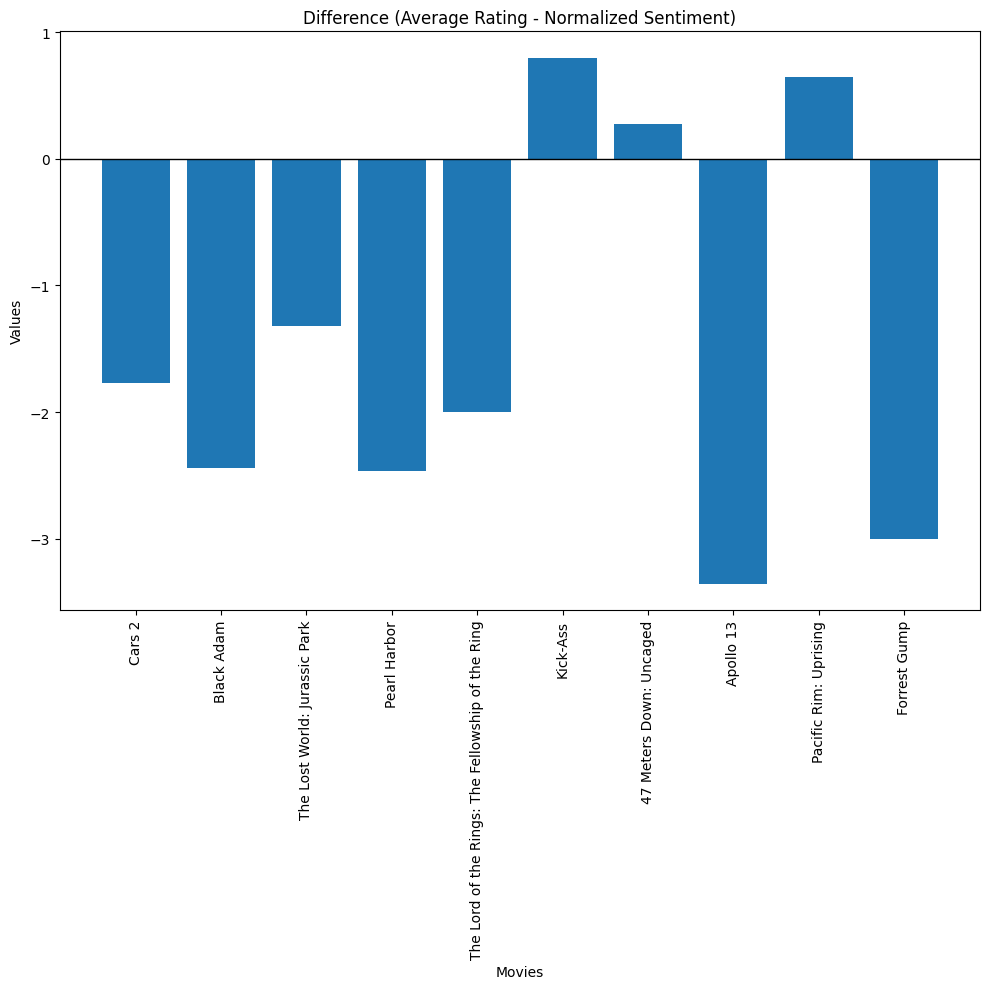

In [272]:
create_plot(result_without_1_10_none_rating_values)

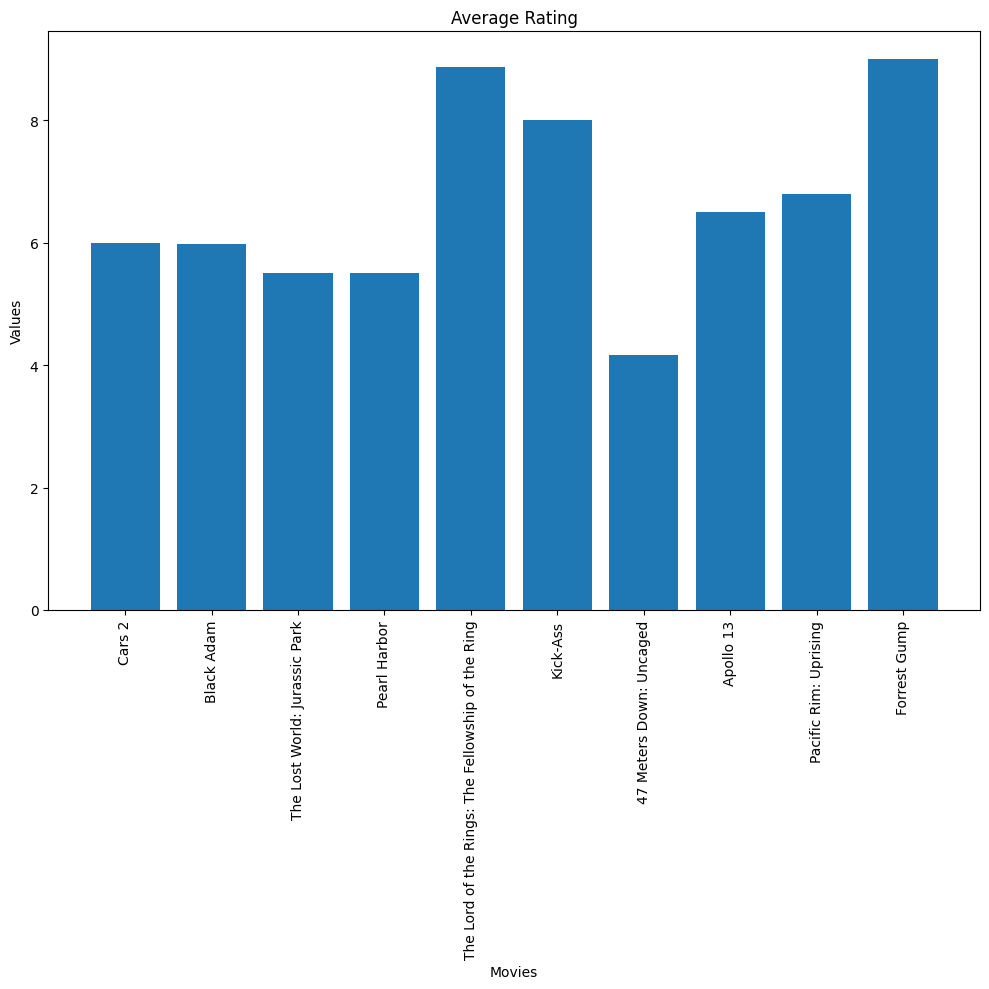

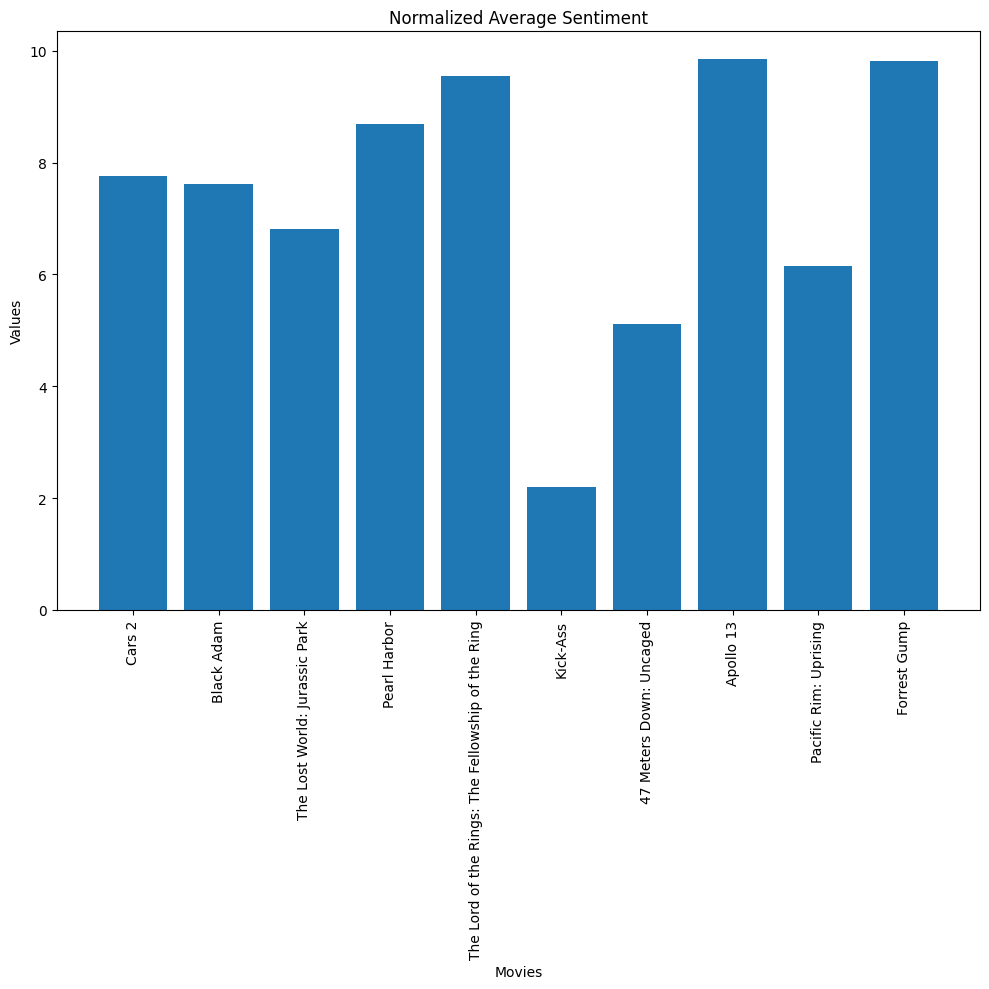

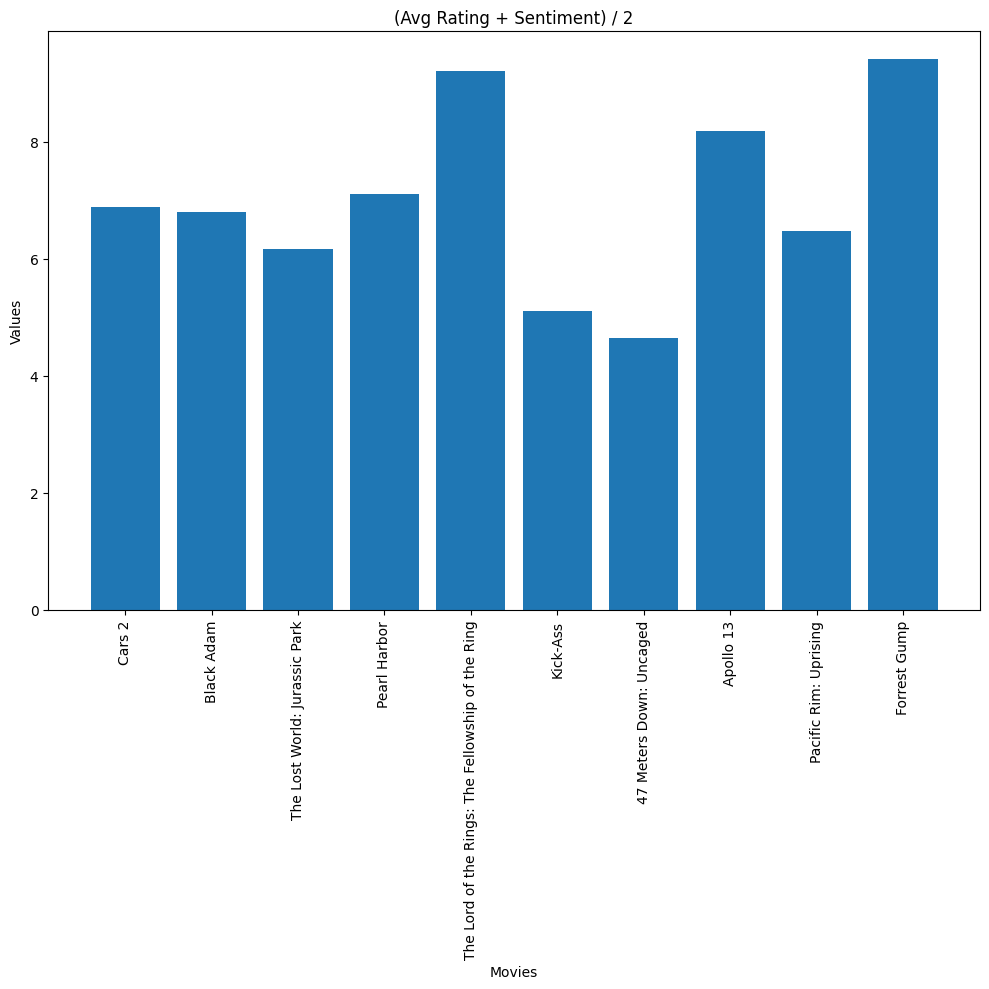

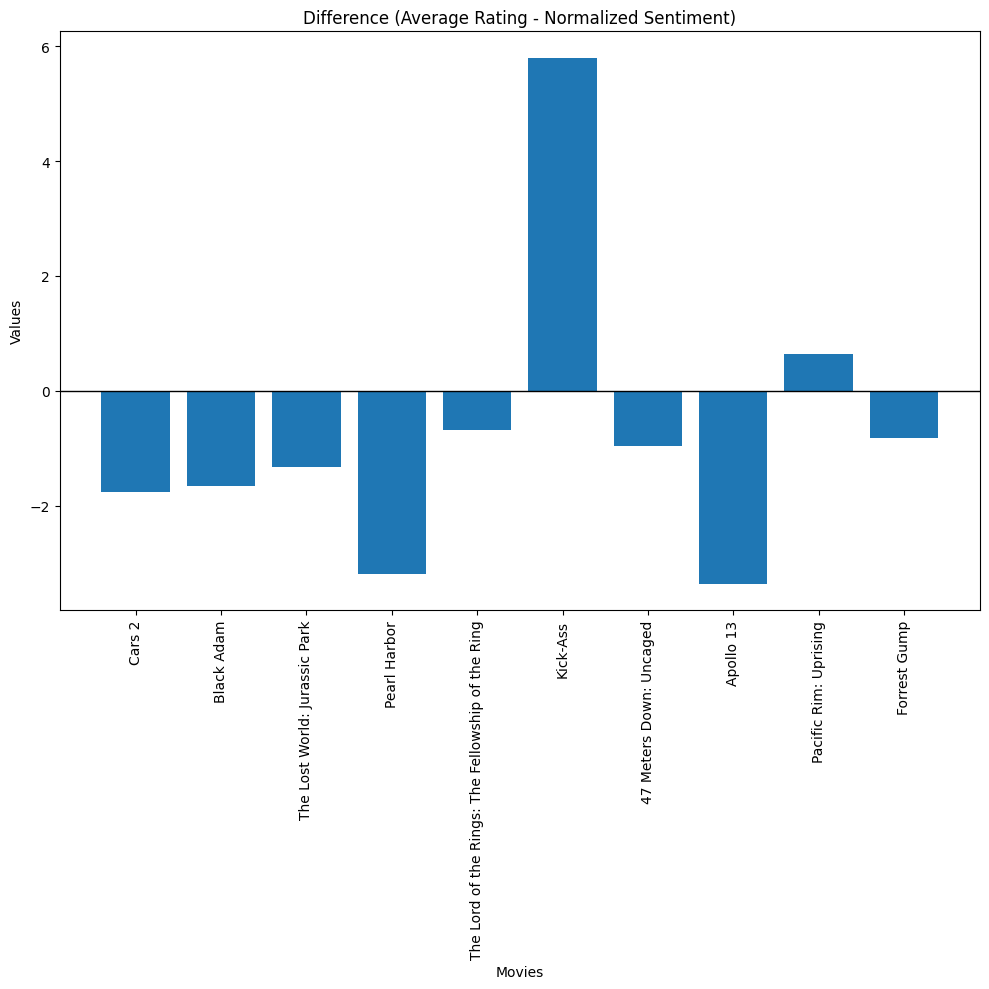

In [273]:
create_plot(result_without_2_9_none_rating_values)

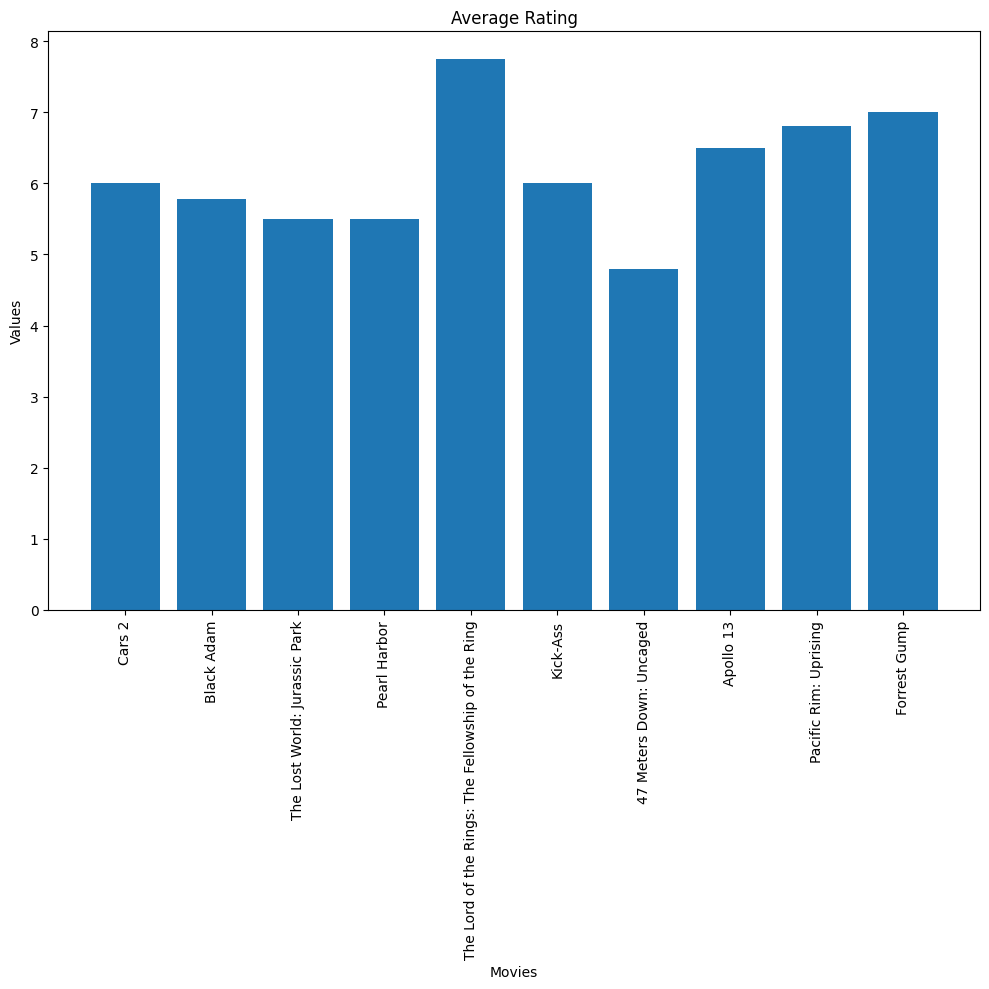

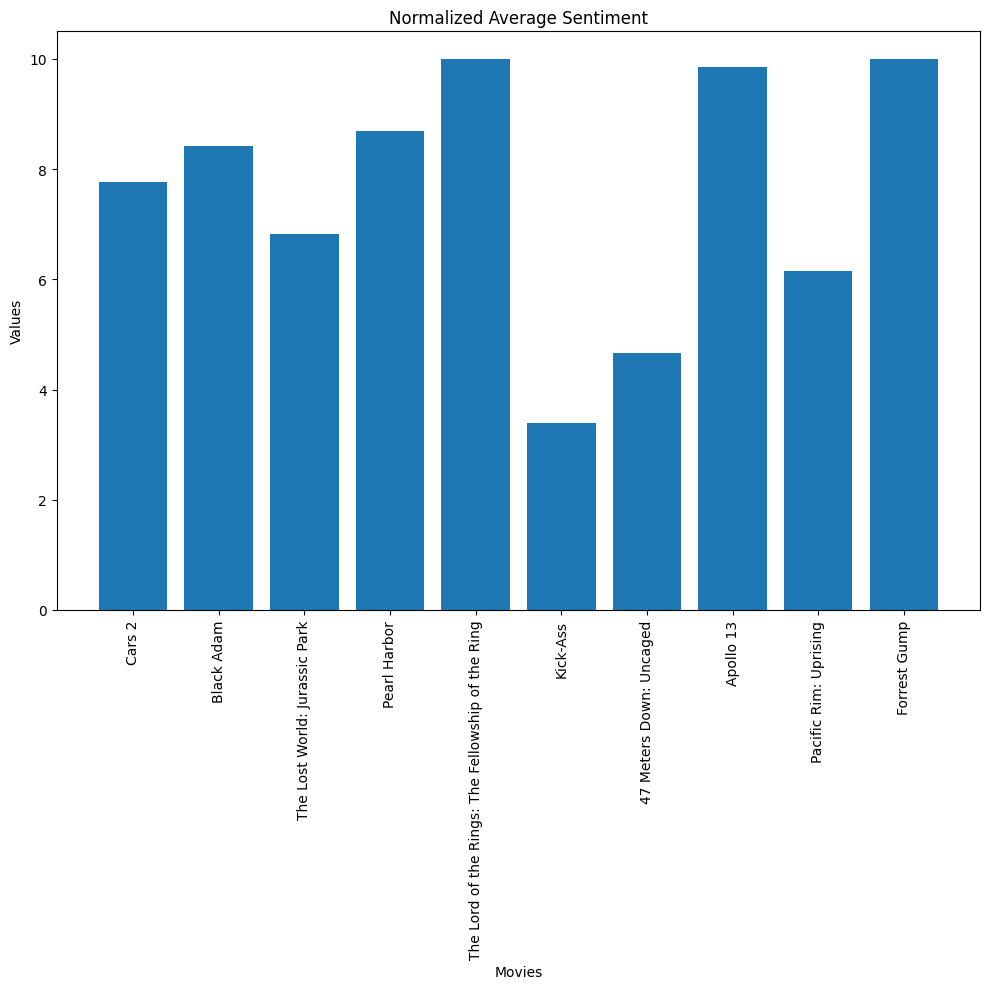

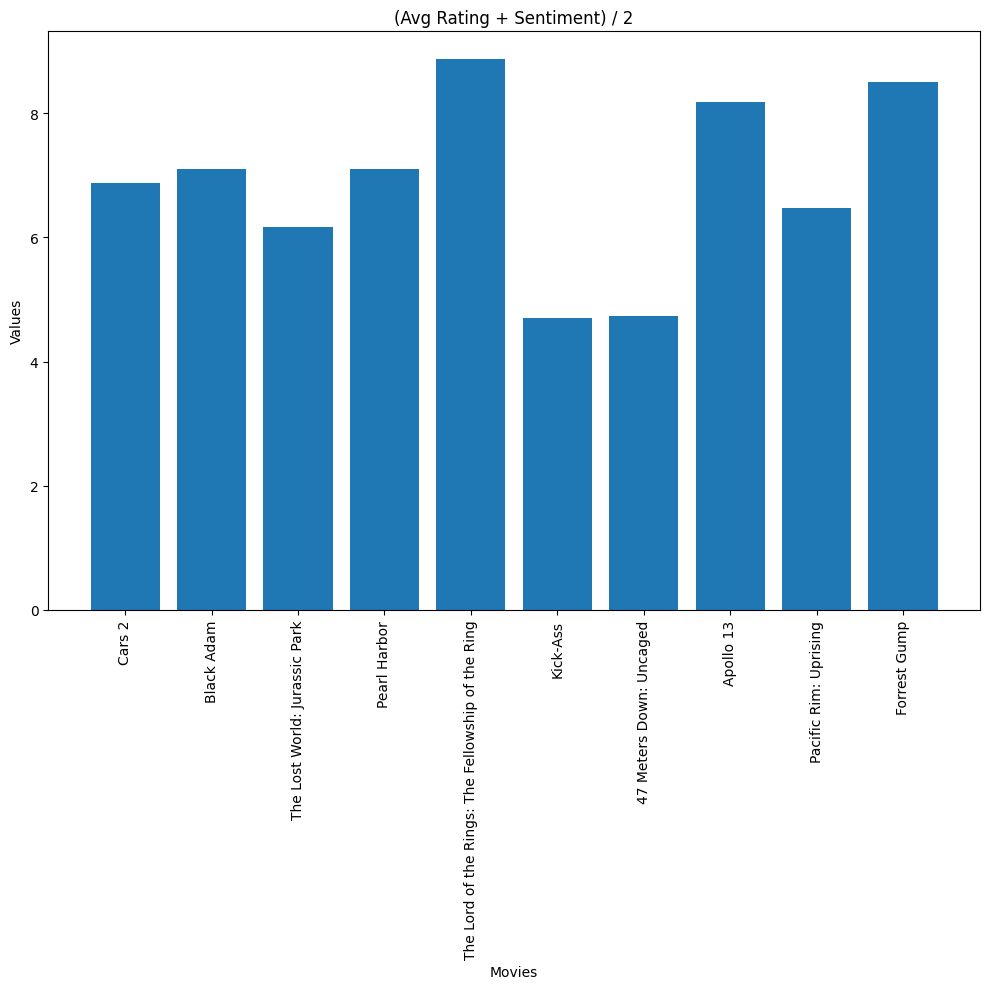

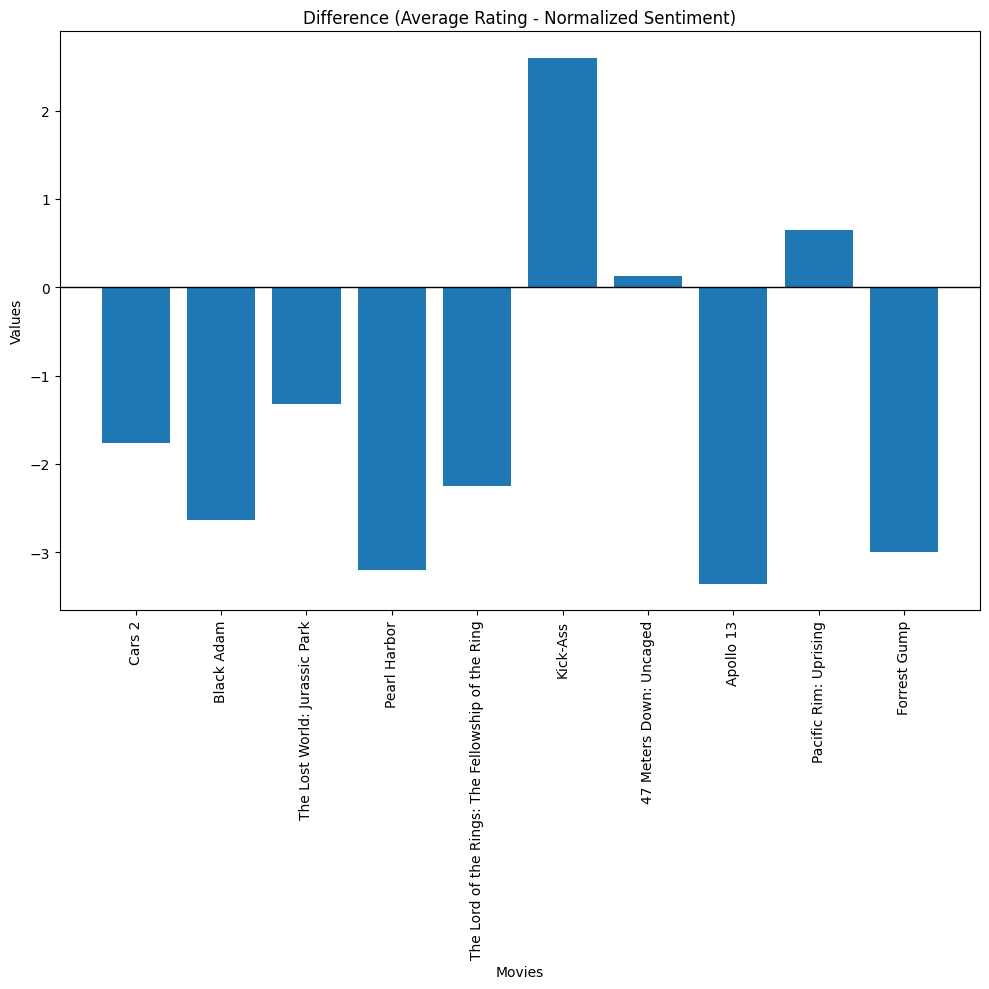

In [274]:
create_plot(result_without_1_2_9_10_none_rating_values)

# Create movie ranking with the different metrics

In [281]:
def create_ranking(result: Dict[str, Dict[str, any]], metric: str) -> None:
    print(f"\nRanking of the movies with the metric: {metric}")
 
    sorted_movies = dict(sorted(result.items(), key=lambda x: x[1]['rating_norm_sentiment_divided'], reverse=True))
    for index, (movie, _) in enumerate(sorted_movies.items(), start=1):
        print(f"\tRank: {index}, movie: {movie}, score: {result[movie]['rating_norm_sentiment_divided']:.2f}")

In [282]:
create_ranking(result_without_none_rating_values, "Result without none rating values")
create_ranking(result_without_1_10_none_rating_values, "Result without 1,10 and none rating values")
create_ranking(result_without_2_9_none_rating_values, "Result without 2,9 and none rating values")
create_ranking(result_without_1_2_9_10_none_rating_values, "Result without 1,2,9,10 and none rating values")


Ranking of the movies with the metric: Result without none rating values
	Rank: 1, movie: Forrest Gump, score: 9.41
	Rank: 2, movie: The Lord of the Rings: The Fellowship of the Ring, score: 9.24
	Rank: 3, movie: Apollo 13, score: 8.18
	Rank: 4, movie: Pearl Harbor, score: 7.90
	Rank: 5, movie: Cars 2, score: 6.88
	Rank: 6, movie: Kick-Ass, score: 6.57
	Rank: 7, movie: Black Adam, score: 6.54
	Rank: 8, movie: Pacific Rim: Uprising, score: 6.48
	Rank: 9, movie: The Lost World: Jurassic Park, score: 6.16
	Rank: 10, movie: 47 Meters Down: Uncaged, score: 4.19

Ranking of the movies with the metric: Result without 1,10 and none rating values
	Rank: 1, movie: The Lord of the Rings: The Fellowship of the Ring, score: 9.00
	Rank: 2, movie: Forrest Gump, score: 8.50
	Rank: 3, movie: Apollo 13, score: 8.18
	Rank: 4, movie: Pearl Harbor, score: 7.90
	Rank: 5, movie: Kick-Ass, score: 7.10
	Rank: 6, movie: Cars 2, score: 6.88
	Rank: 7, movie: Black Adam, score: 6.78
	Rank: 8, movie: Pacific Rim: 